## Classifying Helicopters and Planes

![alt text](https://media.giphy.com/media/4Nq6R70nK4m3qWmkwd/giphy.gif)

From the earliest times on Earth, mankind has gazed upon the sky and heavens with both wonder and awe.I was no different. As a kid I was always fascinated by helicopters, spaceships and anything aerial. With that in mind, I decided to work on something similar. In this project we will build a classifier which will help us identify whether an image is a helicopter or a plane. 

# Data Preparation


To train our model we need data.So I used [Faktun batch downloader chrome extension](https://chrome.google.com/webstore/detail/fatkun-batch-download-ima/nnjjahlikiabnchcpehcpkdeckfgnohf?hl=en) to scrape images from Google. Once that was done, I resized them to 224 pixels and moved them into separate folders. 

In [0]:
#import libraries
from fastai.imports import *

In [0]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [0]:
PATH = "data/plane_copter/"
sz=224

In [0]:
torch.cuda.is_available()

True

In [0]:
torch.backends.cudnn.enabled

True

## Visualization

Before going any further, let's take a look at the images we have at hand.

In [0]:
files = os.listdir(f'{PATH}valid/plane')[:10]
files

['71.jpg',
 '68.jpg',
 '203.jpg',
 '200.jpg',
 '72.jpg',
 '12.jpg',
 '221.jpg',
 '66.jpg',
 '17.jpg',
 '115.jpg']

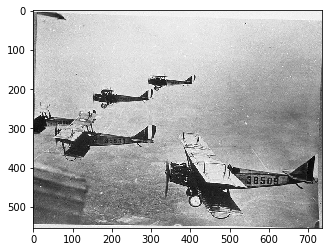

In [0]:
img = plt.imread(f'{PATH}valid/plane/{files[1]}')
plt.imshow(img);

In [0]:
files = os.listdir(f'{PATH}valid/copter')[:10]
files

['335.jpg',
 '337.jpg',
 '225.jpg',
 '97.jpg',
 '166.jpg',
 '323.jpg',
 '216.jpg',
 '174.jpg',
 '171.jpg',
 '12.jpg']

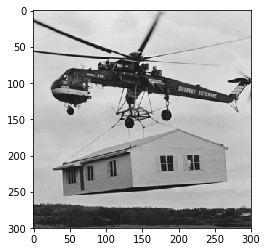

In [0]:
img = plt.imread(f'{PATH}valid/copter/{files[9]}')
plt.imshow(img);

Here is how the raw data looks like

In [0]:
img.shape

(300, 300, 3)

In [0]:
# First 4 rows and columns of the image
img[:4,:4]

array([[[229, 229, 229],
        [228, 228, 228],
        [227, 227, 227],
        [228, 228, 228]],

       [[227, 227, 227],
        [226, 226, 226],
        [225, 225, 225],
        [225, 225, 225]],

       [[227, 227, 227],
        [225, 225, 225],
        [223, 223, 223],
        [224, 224, 224]],

       [[227, 227, 227],
        [225, 225, 225],
        [223, 223, 223],
        [223, 223, 223]]], dtype=uint8)

## Building the first model


We will use the resnet34 model which one the 2015 imagenet competition.For starters, let’s train and evaluate the model.


In [0]:
# Uncomment the below if you need to reset your precomputed activations
# shutil.rmtree(f'{PATH}tmp', ignore_errors=True)

In [0]:
def read_dirs(path, folder):
    labels, filenames, all_labels = [], [], []
    full_path = os.path.join(path, folder)
    for label in sorted(os.listdir(full_path)):
        if label not in ('.ipynb_checkpoints'):
            all_labels.append(label)
            for fname in os.listdir(os.path.join(full_path, label)):
                filenames.append(os.path.join(folder, label, fname))
                labels.append(label)
    return filenames, labels, all_labels

In [0]:
arch=resnet34
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz),bs=8)
learn = ConvLearner.pretrained(arch, data, precompute=True)
# Learning rate = 0.01
learn.fit(0.01, 5)
# Output: Cross entropy loss on training set, validation set, Acc on validation set

epoch      trn_loss   val_loss   accuracy                   
    0      0.451914   0.41048    0.867133  
    1      0.452911   0.438448   0.888112                   
    2      0.430102   0.347808   0.902098                   
    3      0.359223   0.300148   0.902098                   
    4      0.400829   0.301325   0.902098                   



[array([0.30133]), 0.9020979020979021]


With a batch size of 8, 5 epochs and a learning rate of just 0.01 we got an accuracy of around 90%. That’s pretty decent for starters. 


## Analyzing the results

In [0]:
# This is the label for a val data
data.val_y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1])

In [0]:
# this gives prediction for validation set. Predictions are in log scale
# PyTorch generally gives log of predictions instead of probs
log_preds = learn.predict()
log_preds.shape

(143, 2)

In [0]:
log_preds[:10]

array([[ -0.00097,  -6.93848],
       [ -1.29731,  -0.3192 ],
       [ -0.88804,  -0.53011],
       [ -1.39191,  -0.28582],
       [ -0.00116,  -6.75633],
       [ -3.29685,  -0.0377 ],
       [ -0.     , -13.69767],
       [ -0.00786,  -4.85012],
       [ -0.00008,  -9.45263],
       [ -0.00111,  -6.80607]], dtype=float32)

In [0]:
preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1
probs = np.exp(log_preds[:,1])        # pr(dog)

In [0]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

In [0]:
def plot_val_with_title(idxs, title):
    imgs = np.stack([data.val_ds[x][0] for x in idxs])
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs)

In [0]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

In [0]:
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

Correctly classified


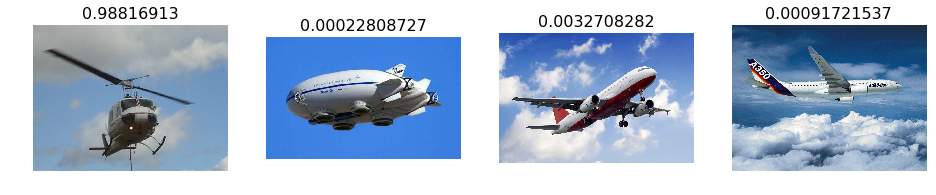

In [0]:
# 1. A few correct labels at random
plot_val_with_title(rand_by_correct(True), "Correctly classified")

Incorrectly classified


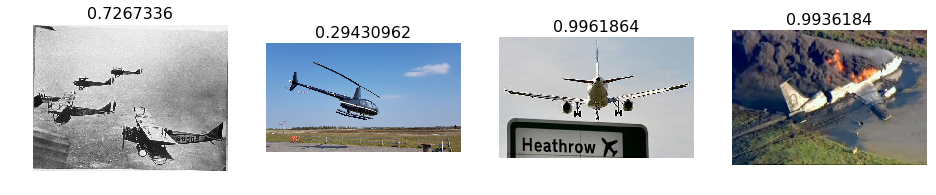

In [0]:
# 2. A few incorrect labels at random
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

In [0]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

Most correct Aeroplanes


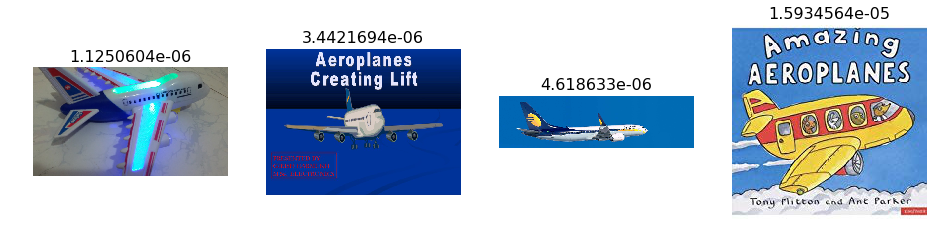

In [0]:
plot_val_with_title(most_by_correct(0, True), "Most correct Aeroplanes")

Most correct Helicopters


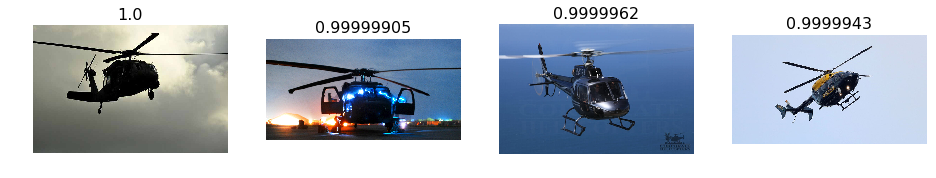

In [0]:
plot_val_with_title(most_by_correct(1, True), "Most correct Helicopters")

Most incorrect Aeroplanes


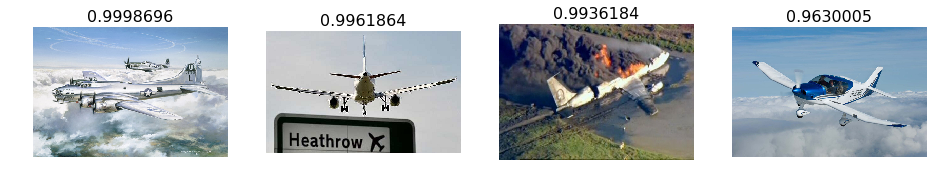

In [0]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect Aeroplanes")

Most incorrect Helicopters


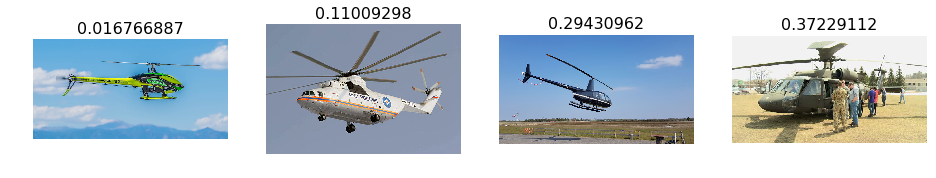

In [0]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect Helicopters")

## Optimizing the learning rate

Learning rate is a hyper-parameter that controls how much we are adjusting the weights of our network with respect the loss gradient.Setting the learning rate is one of the most difficult aspects.


The method learn.lr_find() will help you find an optimal learning rate.It uses a technique called [Cyclical Learning Rate](https://techburst.io/improving-the-way-we-work-with-learning-rate-5e99554f163b) for training Neural Networks where we keep on increasing the learning rate from a very small value until the loss stops decreasing. You can learn more about it [here](https://techburst.io/improving-the-way-we-work-with-learning-rate-5e99554f163b)

In [0]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [0]:
lrf=learn.lr_find()

 26%|██▋       | 14/53 [00:00<00:00, 69.36it/s, loss=6.37]  


Our `learn` object contains an attribute `sched` that contains our learning rate scheduler, and has some convenient plotting functionality including this one:

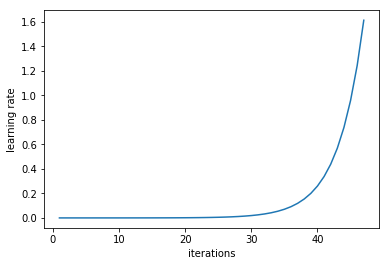

In [0]:
learn.sched.plot_lr()

Note that in the previous plot *iteration* is one iteration (or *minibatch*) of SGD. In one epoch there are 
(num_train_samples/num_iterations) of SGD.

We can see the plot of loss versus learning rate to see where our loss stops decreasing:

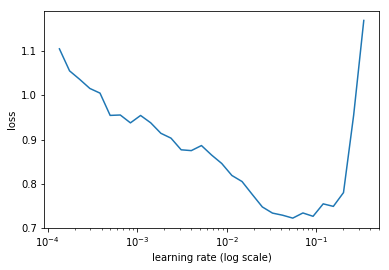

In [0]:
learn.sched.plot()

The loss is still clearly improving at lr=1e-2 (0.01), so that's what we use. Note that the optimal learning rate can change as we training the model, so you may want to re-run this function from time to time.

In [0]:
#np.exp()

## Improving our model

### Data augmentation

If we try training with more epochs, then our model won’t generalize well. We can fix this with the help of more data. This can be done using a method called data augmentation. Augmentation is the method of resizing, flipping and rotating images in different angles in order to create more data.

For that first we pass aug_tfms to tfms_from_model with a list of functions to randomly change the images. In case of pictures on the side, we can use the pre defined list of functions such as transforms_side_on.

In [0]:
tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

In [0]:
def get_augs():
    data = ImageClassifierData.from_paths(PATH, bs=8, tfms=tfms, num_workers=1)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[5]

In [0]:
ims = np.stack([get_augs() for i in range(6)])

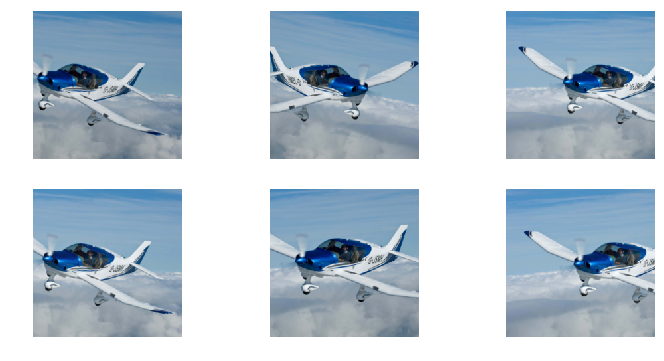

In [0]:
plots(ims, rows=2)

Let's create a new `data` object that includes this augmentation in the transforms.

In [0]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=32)
# Pre computed activations - It will take the activations from the previous model
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [0]:
learn.fit(1e-2, 3)

epoch      trn_loss   val_loss   accuracy         
    0      0.498695   0.246939   0.874126  
    1      0.358275   0.220771   0.881119         
    2      0.286476   0.177933   0.923077         



[array([0.17793]), 0.9230769234937388]

In [0]:
learn.precompute=False

By default when we create a learner, it sets all but the last layer to *frozen*. That means that it's still only updating the weights in the last layer when we call `fit`.

In [0]:
learn.fit(1e-2, 5, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                  
    0      0.16774    0.177738   0.916084  
    1      0.182778   0.184621   0.93007                   
    2      0.219881   0.180831   0.923077                  
    3      0.203141   0.223185   0.916084                  
    4      0.19536    0.198046   0.923077                  



[array([0.19805]), 0.9230769234937388]

The number of epochs between resetting the learning rate is set by `cycle_len`, and the number of times this happens is refered to as the *number of cycles*, and is what we're actually passing as the 2nd parameter to `fit()`. So here's what our actual learning rates looked like:

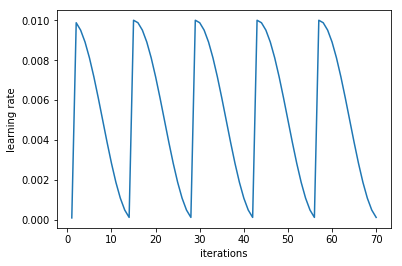

In [0]:
learn.sched.plot_lr()

Our validation loss isn't improving much, so there's probably no point further training the last layer on its own.

Since we've got a pretty good model at this point, we might want to save it so we can load it again later without training it from scratch.

In [0]:
learn.save('224_lastlayer')

In [0]:
learn.load('224_lastlayer')

### Fine-tuning and differential learning rate annealing

Now that we have a good final layer trained, we can try fine-tuning the other layers. To tell the learner that we want to unfreeze the remaining layers, just call (surprise surprise!) `unfreeze()`.

In [0]:
learn.unfreeze()

Note that the other layers have *already* been trained to recognize imagenet photos (whereas our final layers where randomly initialized), so we want to be careful of not destroying the carefully tuned weights that are already there.



In [0]:
lr=np.array([1e-4,1e-3,1e-2])

In [0]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                  
    0      0.242929   0.224041   0.923077  
    1      0.209182   0.234031   0.923077                  
    2      0.153587   0.216259   0.93007                   
    3      0.1491     0.212364   0.916084                  
    4      0.127601   0.211324   0.916084                  
    5      0.152717   0.230876   0.93007                   
    6      0.123288   0.212084   0.93007                   



[array([0.21208]), 0.9300699304867458]

Another trick we've used here is adding the `cycle_mult` parameter. Take a look at the following chart, and see if you can figure out what the parameter is doing:

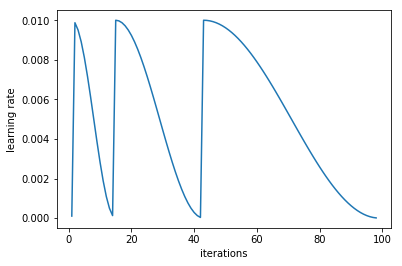

In [0]:
learn.sched.plot_lr()

Please take note that what's being plotted above is the learning rate of the *final layers*. 

In [0]:
learn.save('224_all')

In [0]:
learn.load('224_all')

In [0]:
accuracy_np(probs, y)

0.9440559440559441

As you can see, we have managed to achieve an accuracy of 94% which is pretty decent for such a small dataset.